## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization, ConvLSTM2D
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape, Dropout
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D
from keras.callbacks import ModelCheckpoint, EarlyStopping

#leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
    
from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Using TensorFlow backend.


Notebook running on Python 3.8.11
Numpy version 1.20.3
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: [] )


## Load data from files

In [2]:
datasetRURpath = "dc21-rur-and-gpu-data/RUR/"
datasetGPUpath = "dc21-rur-and-gpu-data/GPU/"

### RUR

In [3]:
df = pd.DataFrame()
files = glob.glob(datasetRURpath + "/20*.csv") 
for filename in files:
    data = pd.read_csv(filename)
    df = df.append(data, ignore_index=True)

In [6]:
dfrur = df.copy()
dfrur['end_time'] = pd.to_datetime(dfrur['end_time'])
dfrur['start_time'] = pd.to_datetime(dfrur['start_time'])
dfrur["duration"] = (dfrur['end_time'] - dfrur['start_time']).dt.total_seconds()
dfrur["i_command_list"] = dfrur["command"].apply(lambda x: x.split("Area"))
dfrur["i_command_len"] = dfrur["i_command_list"].apply(lambda x: len(x))
dfrur.drop(dfrur.loc[dfrur["i_command_len"] == 1].index, inplace=True)
dfrur["area"] = dfrur["i_command_list"].apply(lambda x: x[1].split("-")[0])

In [7]:
dftask3 = dfrur
dftask3 = dftask3[['start_time', 'max_rss', 'stime', 'utime', 'gpu_secs']]
dftask3.index = pd.to_datetime(dftask3['start_time'],format='%m/%d/%y %I:%M%p')
dfgrpr = dftask3.groupby(pd.Grouper(freq='D'))
daycnt = dfgrpr['start_time'].count()
print(daycnt)
dfgrpr = dfgrpr[['max_rss', 'stime', 'utime', 'gpu_secs']].sum()

start_time
2015-03-10      58
2015-03-11     429
2015-03-12    1280
2015-03-13    1531
2015-03-14     974
              ... 
2019-07-09      21
2019-07-10       6
2019-07-11       3
2019-07-12      70
2019-07-13     104
Freq: D, Name: start_time, Length: 1587, dtype: int64


In [8]:
print(dfgrpr.head)
ds = np.array(dfgrpr)
print(ds.shape)

<bound method NDFrame.head of                  max_rss         stime         utime     gpu_secs
start_time                                                       
2015-03-10  8.432820e+07  1.129548e+13  7.069101e+13  124399453.0
2015-03-11  5.383290e+08  2.815336e+13  4.222208e+14   32965933.0
2015-03-12  1.568196e+09  5.682385e+13  4.393597e+14  265798280.0
2015-03-13  1.985900e+09  2.107366e+13  5.103440e+14  209071515.0
2015-03-14  1.061149e+09  2.101353e+13  3.221995e+14   69652114.0
...                  ...           ...           ...          ...
2019-07-09  7.643132e+06  5.075437e+13  1.038368e+15  367430773.0
2019-07-10  3.717160e+07  6.520114e+13  4.055059e+15     184899.0
2019-07-11  2.311513e+07  3.931808e+11  2.135831e+13          0.0
2019-07-12  2.705705e+07  9.135871e+12  1.469318e+14          0.0
2019-07-13  3.510934e+07  1.222513e+13  1.077694e+14    8722956.0

[1587 rows x 4 columns]>
(1587, 4)


In [9]:
dsnorm = []
for feat in range(ds.shape[1]):
    scaler = MinMaxScaler(copy=True)
    norm = scaler.fit_transform(np.expand_dims(ds[:, feat], axis=1))
    dsnorm.append(norm)
dsnorm = np.hstack(dsnorm)
print(dsnorm.shape)

(1587, 4)


In [11]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    n_weeks = int(len(data) / 7)
    ratio = int(n_weeks * 0.8)
    train_weeks = ratio
    test_weeks = n_weeks - ratio
    train, test = data[:train_weeks*7], data[train_weeks*7:(train_weeks*7 + test_weeks*7)]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, :]
            X.append(x_input)
            y.append(data[in_end:out_end, :])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [12]:
train, test = split_dataset(dsnorm)
print(train.shape)
print(test.shape)

(180, 7, 4)
(46, 7, 4)


In [13]:
train_x, train_y = to_supervised(train, 30)
print(train_x.shape)
print(train_y.shape)
test_x, test_y = to_supervised(test, 30)
print(test_x.shape)
print(test_y.shape)

(1224, 30, 4)
(1224, 7, 4)
(286, 30, 4)
(286, 7, 4)


In [14]:
### LSTM Model

# define parameters
verbose, epochs, batch_size = 1, 10000, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(7))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_features))
model.compile(loss='mse', optimizer='adam')

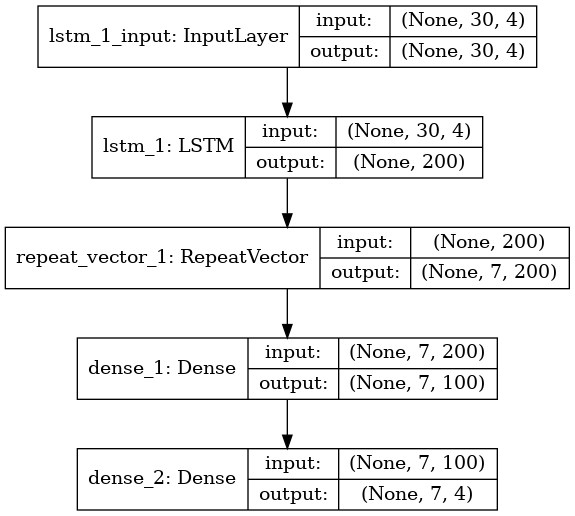

In [15]:
from keras.utils import plot_model
from IPython.display import Image 

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [16]:
%%time
#checkpoint_file= path + "/weights.hdf5"
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, 
                                             verbose=1, restore_best_weights = True)
#checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [earlystop]#, checkpoint]

H = model.fit(train_x, train_y, epochs=epochs, validation_split=0.2,
              verbose=verbose, callbacks=callbacks_list, shuffle=True)

Train on 979 samples, validate on 245 samples
Epoch 1/10000
979/979 [==============================] - 2s 2ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 2/10000
979/979 [==============================] - 1s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 3/10000
979/979 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 4/10000
979/979 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 5/10000
979/979 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0086
Epoch 6/10000
979/979 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0085
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
CPU times: user 42.1 s, sys: 9.21 s, total: 51.4 s
Wall time: 9.86 s


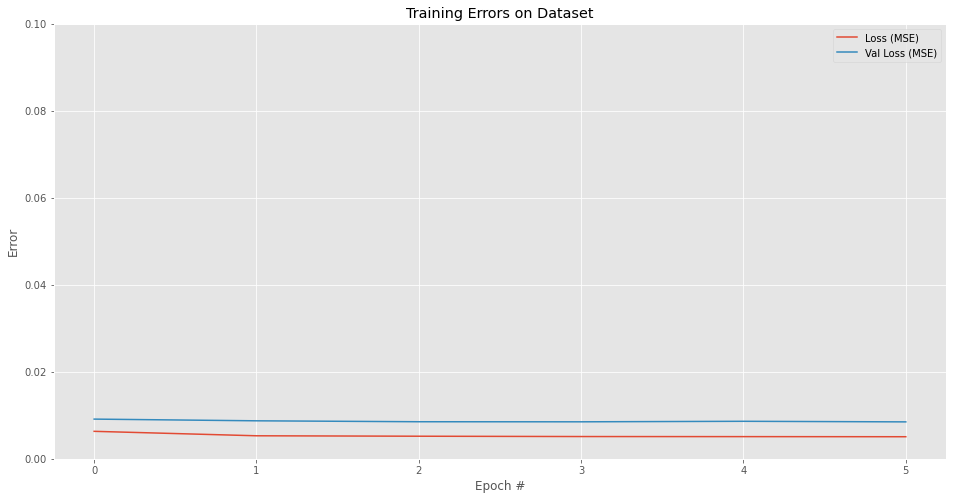

In [19]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
#plt.plot(np.arange(0, N), H.history["loss"], label="Loss (MSE)")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="Val Loss (MSE)")
plt.plot(H.history["loss"], label="Loss (MSE)")
plt.plot(H.history["val_loss"], label="Val Loss (MSE)")
plt.title("Training Errors on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.legend()
plt.ylim(0,0.1)
plt.savefig("plot.png")
plt.show()

In [20]:
results = model.evaluate(train_x, train_y, verbose=0)
print('Train loss: {0:.4g}'.format(results))
results = model.evaluate(test_x, test_y, verbose=0)
print('Test loss: {0:.4g}'.format(results))

Train loss: 0.005827
Test loss: 0.004123
